# Counterfactual Regret Minimization

- Iterative algorithm for computing strategies in extensive-form games
- Learns by playing against itself repeatedly. 
- It starts play with a uniform random strategy and iterates on these strategies to nudge closer to the game theory optimal Nash equilibrium strategy

## Algorithm

1. Initilize the players strategy which is an array describing the probability of choosing an action

2. Iterate for the game and for each players
- (a) calculate the average EV
- (b) calculate the EV for an action
- (c) calculate the regret for an action = (b) - (a)

3. update the strategy by normalizing the <b>accumulated regret</b>

4. repeat step (2) and (3) until strategy converge and reach the Nash equilibrium

## Example 1 - Guess Number Game

There are three players, and each player must pick an integer between 0-100:

One player picks completely randomly

A second player is a completely rational player

Yourself - also a completely rational player.

Rule: The player with the highest number pays the other two the amount they chose. If two players chosen the highest number, they pays half of the payout to smallest players

Goal: maximize the expected payout.

In [61]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd

N = 101
ACTIONS = np.arange(0, N)

'''
    Game outcome given for first player in the input
'''
def game_outcome(numbers: list[int]) -> float:
    m = max(numbers)
    max_players = [i for i, j in enumerate(numbers) if j == m]
    payout = 0

    if len(max_players) == 1:
        payout = sum(numbers) - m        

    elif len(max_players) == 2:
        payout = (sum(numbers) - 2*m) / 2        

    if 0 in max_players:
        return -payout
    else:
        return numbers[0]
        
'''
    Expected value given an action, considering opponent_strategy outcomes
'''
def game_ev(action: int, opponent_strategy: np.ndarray) -> float:
    EV = 0

    # i represents actions of rational players
    # j represents actions of random players
    for i in range(len(ACTIONS)):
        for j in range(len(ACTIONS)):
            EV += opponent_strategy[i] * 1/N * game_outcome([action, ACTIONS[i], ACTIONS[j]])

    return EV

'''
    Caclulate the regret of strategy given opponent_strategy
    regret = EV of an action - EV of all actions given strategy
'''
def calc_immediate_regret(strategy: np.ndarray[float], opponent_strategy: np.ndarray[float]) -> np.ndarray[float]:

    ev_actions = np.zeros(N)
    for a in ACTIONS:
        ev_actions[a] = game_ev(a, opponent_strategy)        

    ev_avg = (strategy * ev_actions).sum()    
    regrets = ev_actions - ev_avg
    return regrets

'''
    Update the new strategy by normalizing positive regrets
'''
def calc_new_strategy(regrets: np.ndarray[float]) -> np.ndarray[float]:
    regrets_pos = np.where(regrets > 0, regrets, 0)
    regrets_norm = regrets_pos / regrets_pos.sum()
    return regrets_norm

In [17]:
strategyA = np.ones(N) / N
strategyB = np.ones(N) / N

acc_regretsA = np.zeros(N)
acc_regretsB = np.zeros(N)

iter = 100

with tqdm(total=iter) as pbar:
    for i in range(iter):

        acc_regretsA += calc_immediate_regret(strategyA, strategyB)
        strategyA = calc_new_strategy(acc_regretsA)

        acc_regretsB += calc_immediate_regret(strategyB, strategyA)
        strategyB = calc_new_strategy(acc_regretsB)
        pbar.update(1)

100%|██████████| 100/100 [02:34<00:00,  1.54s/it]


Text(0.5, 1.0, 'Nash Equilibrium Strategy (Optimal Action = 16)')

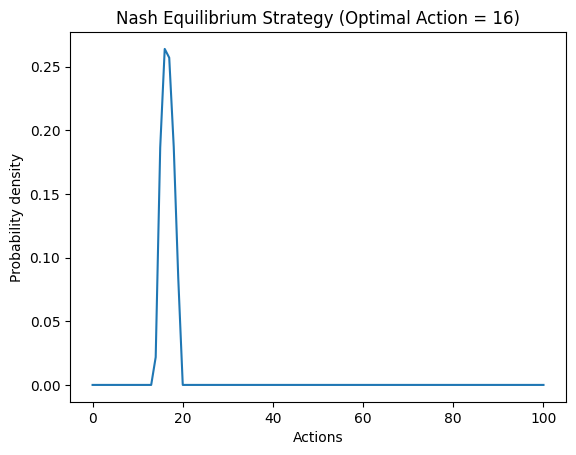

In [28]:
plt.figure()
plt.plot(strategyA)
plt.xlabel('Actions')
plt.ylabel('Probability density')
optimal_action = np.argmax(strategyA)
plt.title(f'Nash Equilibrium Strategy (Optimal Action = {optimal_action})')

# Example 2 - Rock Paper Scissors

In [117]:
'''
Represent actions by their index in the strategy array. Here we will use the convention 
rock     = 0
paper    = 1
scissors = 2
'''

N = 3
ACTIONS = np.arange(0, N)
    
'''
    Expected value given an action, considering opponent_strategy outcomes
'''
def game_ev(action: int, opponent_strategy: np.ndarray) -> float:    

    if action == 0:
        return opponent_strategy[2] - opponent_strategy[1]
    elif action == 1:
        return opponent_strategy[0] - opponent_strategy[2]
    else:
        return opponent_strategy[1] - opponent_strategy[0]

'''
    Caclulate the regret of strategy given opponent_strategy
    regret = EV of an action - EV of all actions given strategy
'''
def calc_immediate_regret(strategy: np.ndarray[float], opponent_strategy: np.ndarray[float]) -> np.ndarray[float]:

    ev_actions = np.zeros(N)
    for a in ACTIONS:
        ev_actions[a] = game_ev(a, opponent_strategy)        

    ev_avg = (strategy * ev_actions).sum()    
    regrets = ev_actions - ev_avg
    return regrets

'''
    Update the new strategy by normalizing positive regrets
'''
def calc_new_strategy(regrets: np.ndarray[float]) -> np.ndarray[float]:
    regrets_pos = np.where(regrets > 0, regrets, 0)
    if regrets_pos.sum() == 0:
        return np.ones(N) / N
    else:
        return regrets_pos / regrets_pos.sum()    


In [118]:
strategyA = np.array([1,0,0])
strategyB = np.array([1,0,0])

acc_regretsA = np.zeros(N)
acc_regretsB = np.zeros(N)

strategyA_hist = []
strategyB_hist = []

iter = 100

with tqdm(total=iter) as pbar:
    for i in range(iter):

        acc_regretsA += calc_immediate_regret(strategyA, strategyB)
        strategyA = calc_new_strategy(acc_regretsA)

        acc_regretsB += calc_immediate_regret(strategyB, strategyA)
        strategyB = calc_new_strategy(acc_regretsB)

        strategyA_hist.append(strategyA)
        strategyB_hist.append(strategyB)

        pbar.update(1)

100%|██████████| 100/100 [00:00<00:00, 53274.53it/s]


Text(0.5, 0, 'CFR step')

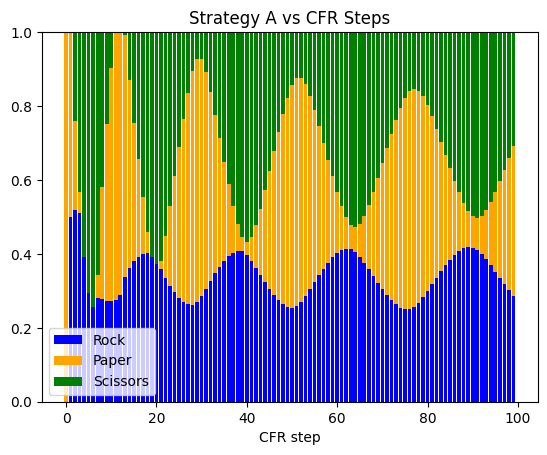

In [119]:
rock = np.array([a[0] for a in strategyA_hist])
paper = np.array([a[1] for a in strategyA_hist])
scissors = np.array([a[2] for a in strategyA_hist])
indices = np.arange(len(strategyA_hist))

fig, ax = plt.subplots()
ax.bar(indices, rock, color='blue', label='Rock')
ax.bar(indices, paper, bottom=rock, color='orange', label='Paper')
ax.bar(indices, scissors, bottom=np.add(rock, paper), color='green', label='Scissors')
ax.set_title('Strategy A vs CFR Steps')
ax.legend()
ax.set_xlabel('CFR step')


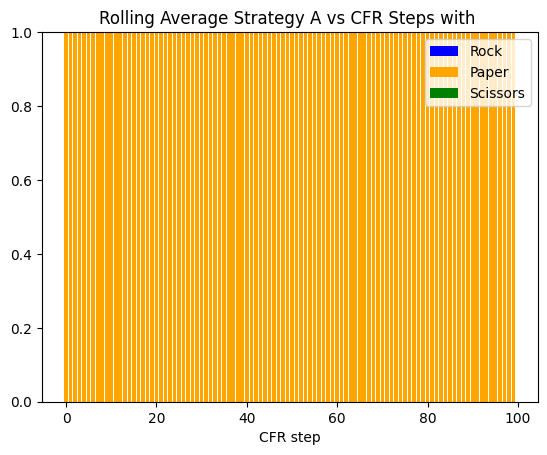

In [123]:
strategyA_hist_avg = pd.DataFrame(strategyA_hist).rolling(100, min_periods=1, axis=0).mean().values

rock = np.array([a[0] for a in strategyA_hist_avg])
paper = np.array([a[1] for a in strategyA_hist_avg])
scissors = np.array([a[2] for a in strategyA_hist_avg])
indices = np.arange(len(strategyA_hist_avg))

fig, ax = plt.subplots()
ax.bar(indices, rock, color='blue', label='Rock')
ax.bar(indices, paper, bottom=rock, color='orange', label='Paper')
ax.bar(indices, scissors, bottom=np.add(rock, paper), color='green', label='Scissors')
ax.set_title('Rolling Average Strategy A vs CFR Steps with ')
ax.legend()
ax.set_xlabel('CFR step')
plt.show()

# Rock Paper Scissors But with fixed opponent strategy

## Opponent takes rock all the time

100%|██████████| 100/100 [00:00<00:00, 91339.37it/s]


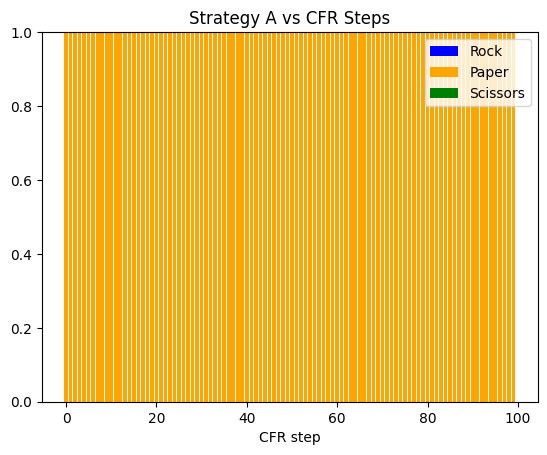

In [124]:
strategyA = np.array([1,0,0])
strategyB = np.array([1,0,0])

acc_regretsA = np.zeros(N)
acc_regretsB = np.zeros(N)

strategyA_hist = []
strategyB_hist = []

iter = 100

with tqdm(total=iter) as pbar:
    for i in range(iter):
        acc_regretsA += calc_immediate_regret(strategyA, strategyB)
        strategyA = calc_new_strategy(acc_regretsA)        
        strategyA_hist.append(strategyA)    
        pbar.update(1)

rock = np.array([a[0] for a in strategyA_hist])
paper = np.array([a[1] for a in strategyA_hist])
scissors = np.array([a[2] for a in strategyA_hist])
indices = np.arange(len(strategyA_hist))

fig, ax = plt.subplots()
ax.bar(indices, rock, color='blue', label='Rock')
ax.bar(indices, paper, bottom=rock, color='orange', label='Paper')
ax.bar(indices, scissors, bottom=np.add(rock, paper), color='green', label='Scissors')
ax.set_title('Strategy A vs CFR Steps')
ax.legend()
ax.set_xlabel('CFR step')
plt.show()

## Opponent takes 34% rock / 33% paper / 33% scissors

100%|██████████| 100/100 [00:00<00:00, 125803.96it/s]


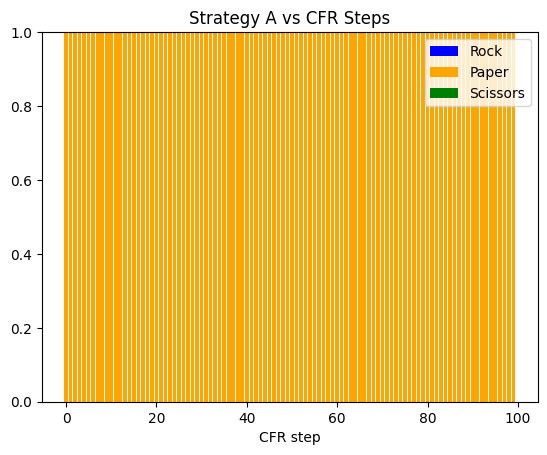

In [125]:
strategyA = np.array([1,0,0])
strategyB = np.array([1+1e-15,1,1])
strategyB = strategyB / strategyB.sum()

acc_regretsA = np.zeros(N)
acc_regretsB = np.zeros(N)

strategyA_hist = []
strategyB_hist = []

iter = 100

with tqdm(total=iter) as pbar:
    for i in range(iter):
        acc_regretsA += calc_immediate_regret(strategyA, strategyB)        
        strategyA = calc_new_strategy(acc_regretsA)        
        strategyA_hist.append(strategyA)    
        pbar.update(1)

rock = np.array([a[0] for a in strategyA_hist])
paper = np.array([a[1] for a in strategyA_hist])
scissors = np.array([a[2] for a in strategyA_hist])
indices = np.arange(len(strategyA_hist))

fig, ax = plt.subplots()
ax.bar(indices, rock, color='blue', label='Rock')
ax.bar(indices, paper, bottom=rock, color='orange', label='Paper')
ax.bar(indices, scissors, bottom=np.add(rock, paper), color='green', label='Scissors')
ax.set_title('Strategy A vs CFR Steps')
ax.legend()
ax.set_xlabel('CFR step')
plt.show()